<a href="https://colab.research.google.com/github/Sreelakshmi2023/MAINPROJECT-GROUP12/blob/main/cnn%2Btcn%2Blstm4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install keras-tcn

In [4]:
from tcn import TCN

In [ ]:
!pip install google-colab
from google.colab import drive
drive.mount('/content/drive')

In [7]:
data = pd.read_csv('/content/drive/MyDrive/MAINPROJECT/malicious_phish.csv')

In [8]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [9]:
data["type"].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [10]:
data["url_type"] = data["type"].replace({
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
});

In [11]:
data.head()

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [14]:
# Assuming your CSV has columns 'url' and 'type'
urls = data['url'].tolist()
labels = data['type'].tolist()

In [15]:
# Convert labels to numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [16]:
# Tokenization and padding
max_sequence_length = 100  # You can adjust this based on your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

In [18]:
# Model definition
model = Sequential()

In [19]:
# Embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))

In [20]:
# CNN layer
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))

In [21]:
# TCN layer
model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16]))

In [23]:
# LSTM layer
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the reserved 0 index

from keras.layers import Embedding

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the reserved 0 index
embedding_dim = 64  # Adjust as needed

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64))

In [24]:
# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Multi-class classification

In [25]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

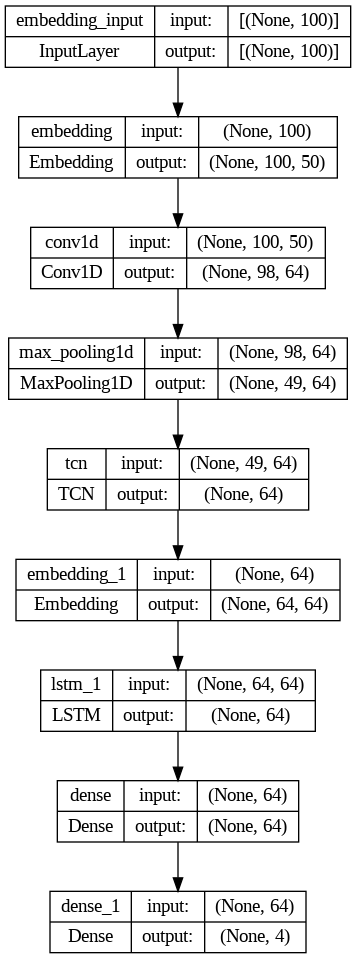

In [27]:
# Plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
  816/16280 [>.............................] - ETA: 1:48:16 - loss: 0.9928 - accuracy: 0.6553

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
rounded_accuracy = round(accuracy, 4)
print("Test Accuracy:", rounded_accuracy*100)

In [ ]:
# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

In [ ]:
# Now, the model is trained. You can use it to make predictions on new URLs.
def predict_maliciousness(url):
    sequence = tokenizer.texts_to_sequences([url])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)
    class_index = np.argmax(prediction[0])
    classes = label_encoder.classes_
    return classes[class_index]


In [ ]:
# Example usage:
user_url = "www.google.com"
prediction = predict_maliciousness(user_url)
print(f"The URL {user_url} is predicted as: {prediction}")